In [1]:
from wisp.cuda_guard import setup_cuda_context
setup_cuda_context()  # Must be called before any torch operations take place

In [2]:
import os
import argparse
import logging
import torch
import numpy as np
from wisp.app_utils import default_log_setup, args_to_log_format
from wisp.framework import WispState
from wisp.datasets import MultiviewDataset
from wisp.datasets.transforms import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.grids import OctreeGrid, HashGrid
from wisp.models.pipeline import Pipeline
from wisp.tracers import PackedRFTracer
from funny_neural_field import FunnyNeuralField

import matplotlib.pyplot as plt


c:\Users\User\.conda\envs\wisp\lib\site-packages\tqdm-4.64.1-py3.7.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_path='datasets\greendino'

# NeRF is trained with a MultiviewDataset, which knows how to generate RGB rays from a set of images + cameras
train_dataset = MultiviewDataset(
    dataset_path=dataset_path,
    multiview_dataset_format='standard',
    mip=0,
    bg_color='white',
    dataset_num_workers=4,
    transform=SampleRays(
        num_samples=4096
    )
)

  0%|          | 0/209 [00:05<?, ?it/s]


In [3]:
torch.cuda.empty_cache()

In [5]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |  224678 KB |   84075 MB |   84075 MB |
|       from large pool |       0 B  |  224676 KB |   84070 MB |   84070 MB |
|       from small pool |       0 B  |      20 KB |       5 MB |       5 MB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |  224678 KB |   84075 MB |   84075 MB |
|       from large pool |       0 B  |  224676 KB |   84070 MB |

In [7]:
#from FusedNEF import FusedNeuralRadianceField, FusedHashGrid
#grid = FusedHashGrid()

grid = HashGrid.from_geometric(feature_dim=2,
                               num_lods=16,
                               multiscale_type='cat',
                               codebook_bitwidth=14,
                               min_grid_res=16,
                               max_grid_res=2048,
                               blas_level=7)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 2.00 GiB total capacity; 1.55 GiB already allocated; 0 bytes free; 1.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
#nerf = FunnyNeuralField(grid=grid)

from wisp.models.nefs import NeuralRadianceField
nerf = NeuralRadianceField( grid=grid,
                            view_embedder='positional',
                            hidden_dim = 128,
                            prune_density_decay=0.95,
                            prune_min_density=0.01*1024/np.sqrt(3)
                            )

In [8]:
#nerf = FusedNeuralRadianceField(grid)

In [9]:
tracer = PackedRFTracer(raymarch_type='ray', num_steps=1024)
pipeline = Pipeline(nef=nerf, tracer=tracer).to(device)

In [10]:
scene_state = WispState()

In [11]:
from wisp.trainers import MultiviewTrainer

In [13]:
lr = 0.001
weight_decay = 0
exp_name = 'siggraph_2022_demo'
trainer = MultiviewTrainer(pipeline=pipeline,
                           dataset=train_dataset,
                           num_epochs=args.epochs,
                           batch_size=1,    # 1 image per batch
                           optim_cls=torch.optim.RMSprop,
                           lr=0.001,
                           weight_decay=0.0,     # Weight decay, applied only to decoder weights.
                           grid_lr_weight=100.0, # Relative learning rate weighting applied only for the grid parameters
                           optim_params=dict(lr=lr, weight_decay=weight_decay),
                           log_dir='_results/logs/runs/',
                           device=device,
                           exp_name=exp_name,
                           info='',
                           extra_args=dict(  # TODO (operel): these should be optional..
                               dataset_path=args.dataset_path,
                               dataloader_num_workers=0,
                               num_lods=4,
                               grow_every=-1,
                               only_last=False,
                               resample=False,
                               resample_every=-1,
                               prune_every=-1,
                               random_lod=False,
                               rgb_loss=1.0,
                               camera_origin=[-2.8, 2.8, -2.8],
                               camera_lookat=[0, 0, 0],
                               camera_fov=30,
                               camera_clamp=[0, 10],
                               render_batch=4000,
                               bg_color='black',
                               valid_every=-1,
                               save_as_new=False,
                               model_format='full',
                               mip=0
                           ),
                           render_tb_every=100,
                           save_every=100,
                           scene_state=scene_state,
                           trainer_mode='train',
                           using_wandb=False)

In [16]:
trainer.train()

KeyboardInterrupt: 

In [17]:
trainer.begin_epoch()

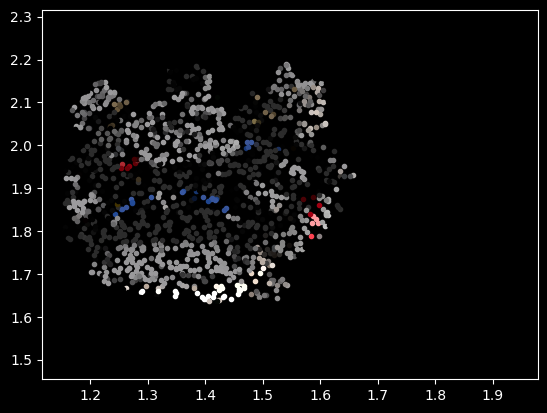

In [30]:
data=next(trainer.train_data_loader_iter)
for i in range(len(data['rays'])):
    plt.plot(torch.arccos(data['rays'][i].dirs[0]).numpy(),torch.arccos(data['rays'][i].dirs[1]).numpy(),'.',color=data['imgs'][0][i].numpy())


In [19]:
import numpy as np

In [20]:
d=None
num_angles=1
camera_distance=5

angles = np.pi * np.array([0.7])
x = -camera_distance * np.sin(angles)
y = 0.1
z = -camera_distance * np.cos(angles)
for idx in range(len(angles)):
    out = trainer.renderer.shade_images(
                    trainer.pipeline,
                    f=[x[idx], y, z[idx]],
                    t=trainer.extra_args["camera_lookat"],
                    fov=trainer.extra_args["camera_fov"],
                    lod_idx=d,
                    camera_clamp=trainer.extra_args["camera_clamp"]
                )

In [21]:
out.image().numpy_dict().keys()

dict_keys(['rgb', 'alpha', 'depth', 'hit'])

In [22]:
out.image().numpy_dict()['rgb'].shape

(1024, 720, 3)

In [23]:
np.max(out.image().numpy_dict()['rgb'])

255.0

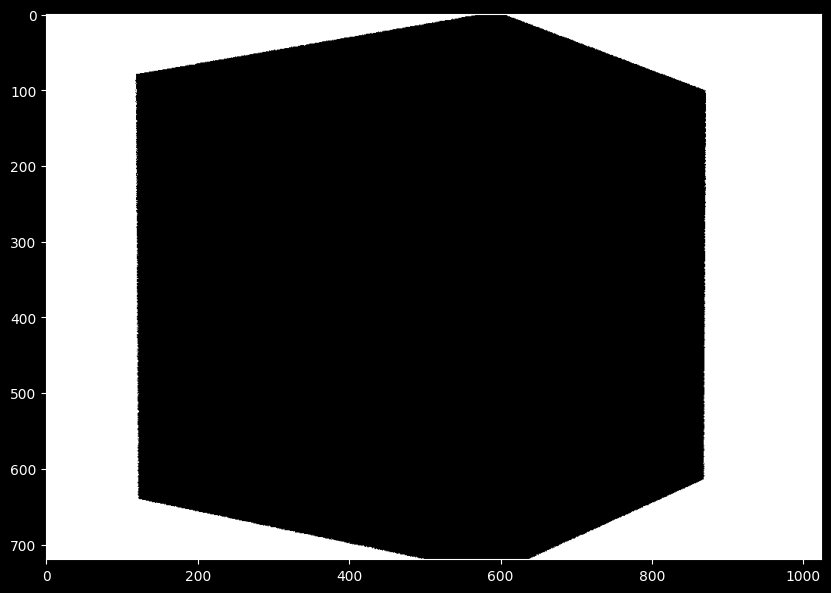

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(out.image().numpy_dict()['rgb'].astype(int).transpose(1,0,2))

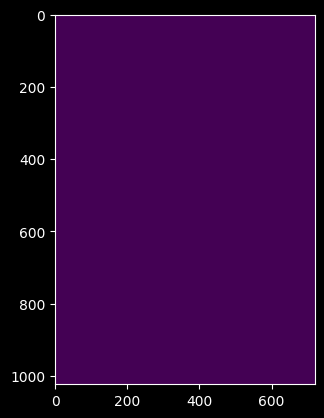

In [29]:
plt.imshow(out.image().numpy_dict()['rgb'].astype(int)[:,:,0]-out.image().numpy_dict()['rgb'].astype(int)[:,:,1])